In [1]:
from google.colab import files
uploaded = files.upload()  # Upload the zipped dataset


Saving EuroSAT.zip to EuroSAT.zip


In [2]:
import zipfile
import os

# Unzip the uploaded file
zip_filename = list(uploaded.keys())[0]  # Get uploaded file name
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('./data')  # Extract to a "data" directory

# Set the directory for the dataset
train_dir = './data/2750'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(train_dir)
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)


Found 27000 images belonging to 10 classes.
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [30]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [31]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # Increased epochs for better learning
NUM_CLASSES = 10  # Change according to your dataset

In [32]:
# Data preprocessing with mild augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 21600 images belonging to 10 classes.


In [34]:
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5400 images belonging to 10 classes.


In [35]:
print(np.bincount(train_generator.classes))
print(np.bincount(val_generator.classes))

[2400 2400 2400 2000 2000 1600 2000 2400 2000 2400]
[600 600 600 500 500 400 500 600 500 600]


In [36]:
# Load EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze the entire model for fine-tuning

In [37]:
# Freeze initial layers and fine-tune deeper layers
for layer in base_model.layers[:100]:
    layer.trainable = False

In [38]:
# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

In [39]:
model = Model(inputs=base_model.input, outputs=x)

In [40]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 449s 515ms/step - accuracy: 0.4632 - loss: 1.4549 - val_accuracy: 0.6643 - val_loss: 1.0236
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 479ms/step - accuracy: 0.7493 - loss: 0.7095 - val_accuracy: 0.7926 - val_loss: 0.6564
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 344s 509ms/step - accuracy: 0.8338 - loss: 0.4787 - val_accuracy: 0.8533 - val_loss: 0.4525
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 324s 479ms/step - accuracy: 0.8728 - loss: 0.3772 - val_accuracy: 0.8700 - val_loss: 0.4145
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 320s 474ms/step - accuracy: 0.8932 - loss: 0.3138 - val_accuracy: 0.8911 - val_loss: 0.3396
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 331s 488ms/step - accuracy: 0.9072 - loss: 0.2639 - val_accuracy: 0.8902 - val_loss: 0.3504
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 321s 476ms/step - accuracy: 0.9187 - loss: 0.2408 - val_accuracy: 0.9069 - val_loss: 0.2937
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 344s 508ms/step - accuracy: 0.9233 -

In [42]:
# Save the model
model.save('efficientnet_lulc_finetuned.h5')

In [43]:
# Evaluate model
y_true = val_generator.classes  # True labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 413ms/step


In [44]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Accuracy: 0.1017
Precision: 0.1015
Recall: 0.1017
F1 Score: 0.1012

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.12      0.12       600
           1       0.11      0.13      0.12       600
           2       0.09      0.11      0.10       600
           3       0.10      0.10      0.10       500
           4       0.08      0.08      0.08       500
           5       0.08      0.07      0.07       400
           6       0.09      0.07      0.08       500
           7       0.10      0.10      0.10       600
           8       0.12      0.11      0.11       500
           9       0.11      0.10      0.11       600

    accuracy                           0.10      5400
   macro avg       0.10      0.10      0.10      5400
weighted avg       0.10      0.10      0.10      5400



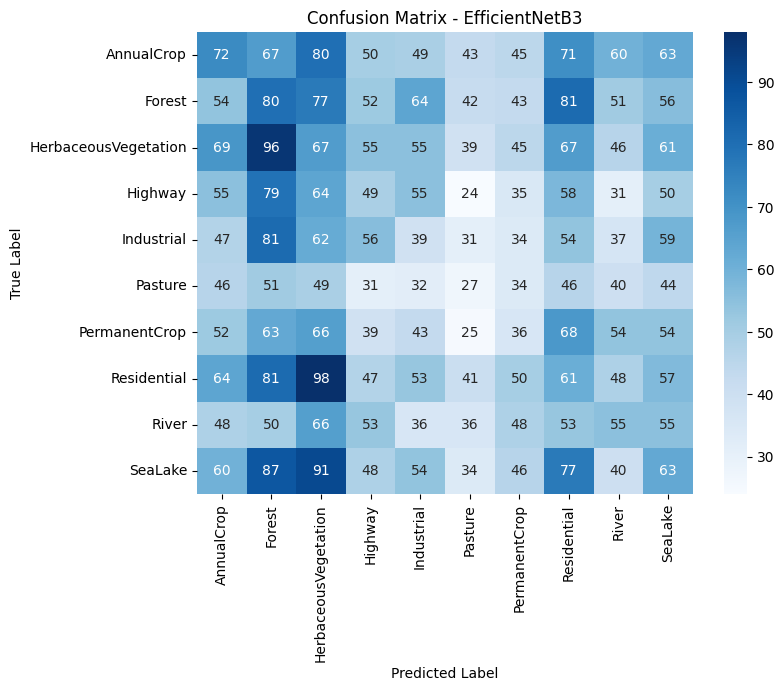

In [45]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNetB3")
plt.show()

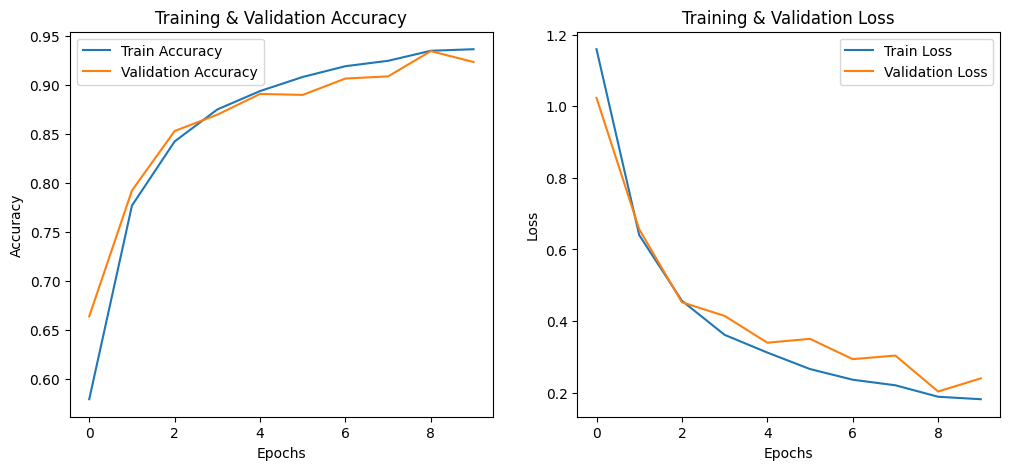

In [46]:
# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [48]:
from google.colab import files  # Only needed if using Google Colab

# Download the model (for local Jupyter Notebook or Colab)
files.download('efficientnet_lulc_finetuned.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>